In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from PIL import Image
import torchvision.transforms.functional as TF
import requests
from io import BytesIO

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.device(0))
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

0
1
Tesla T4


In [57]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [58]:
"""class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x"""

'class ColorizationNet(nn.Module):\n    def __init__(self):\n        super(ColorizationNet, self).__init__()\n        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)\n        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)\n        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)\n        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)\n\n    def forward(self, x):\n        x = nn.functional.relu(self.conv1(x))\n        x = nn.functional.relu(self.conv2(x))\n        x = nn.functional.relu(self.conv3(x))\n        x = torch.sigmoid(self.conv4(x))\n        return x'

In [59]:
import torch
import torch.nn as nn

class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.output_conv = nn.Conv2d(64, 3, kernel_size=1)  # RGB output

    def forward(self, x):
        # Encoder
        encoded = self.encoder(x)
        # Middle
        middle = self.middle(encoded)
        # Decoder
        decoded = self.decoder(middle)
        # Output
        out = self.output_conv(decoded)
        return out


In [60]:
model = ColorizationNet().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

In [61]:

EPOCHS = 80
training_losses = []
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_losses.append(loss.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Finished Training")

Epoch [1/80], Step [1/782], Loss: 0.4012
Epoch [1/80], Step [101/782], Loss: 0.0154
Epoch [1/80], Step [201/782], Loss: 0.0111
Epoch [1/80], Step [301/782], Loss: 0.0099
Epoch [1/80], Step [401/782], Loss: 0.0099
Epoch [1/80], Step [501/782], Loss: 0.0076
Epoch [1/80], Step [601/782], Loss: 0.0082
Epoch [1/80], Step [701/782], Loss: 0.0088
Epoch [2/80], Step [1/782], Loss: 0.0103
Epoch [2/80], Step [101/782], Loss: 0.0081
Epoch [2/80], Step [201/782], Loss: 0.0101
Epoch [2/80], Step [301/782], Loss: 0.0081
Epoch [2/80], Step [401/782], Loss: 0.0071
Epoch [2/80], Step [501/782], Loss: 0.0071
Epoch [2/80], Step [601/782], Loss: 0.0092
Epoch [2/80], Step [701/782], Loss: 0.0067
Epoch [3/80], Step [1/782], Loss: 0.0081
Epoch [3/80], Step [101/782], Loss: 0.0067
Epoch [3/80], Step [201/782], Loss: 0.0069
Epoch [3/80], Step [301/782], Loss: 0.0069
Epoch [3/80], Step [401/782], Loss: 0.0077
Epoch [3/80], Step [501/782], Loss: 0.0064
Epoch [3/80], Step [601/782], Loss: 0.0059
Epoch [3/80], Ste

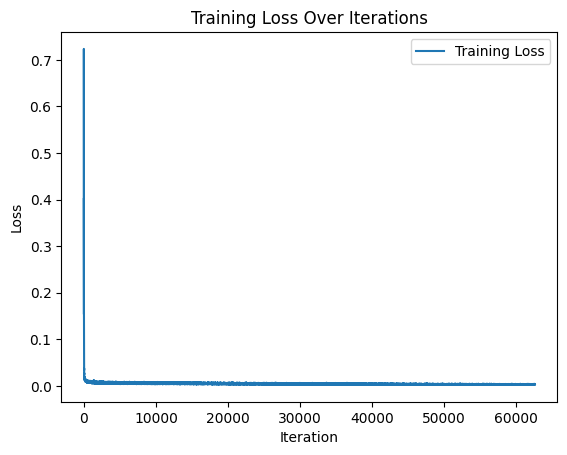

In [62]:
import matplotlib.pyplot as plt


plt.plot(training_losses, label='Training Loss')


plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')

plt.legend()

plt.show()


In [63]:
def imshow(img):
    # Convert from Tensor image and display
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if len(img.shape) == 2:  # grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):

    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        # Display original grayscale image
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def torch_rgb_to_hsv(rgb):

    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val

    # Compute H
    h = torch.zeros_like(r)
    mask = (max_val == r) & (g >= b)
    h[mask] = (g[mask] - b[mask]) / diff[mask]
    mask = (max_val == r) & (g < b)
    h[mask] = (g[mask] - b[mask]) / diff[mask] + 6.0
    mask = max_val == g
    h[mask] = (b[mask] - r[mask]) / diff[mask] + 2.0
    mask = max_val == b
    h[mask] = (r[mask] - g[mask]) / diff[mask] + 4.0
    h = h / 6.0
    h[diff == 0.0] = 0.0

    # Compute S
    s = torch.zeros_like(r)
    s[diff != 0.0] = diff[diff != 0.0] / max_val[diff != 0.0]

    # V is just max_val
    v = max_val

    return torch.stack([h, s, v], dim=1)


def torch_hsv_to_rgb(hsv):

    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = i % 6
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    r[i_mod == 0.0] = v[i_mod == 0.0]
    g[i_mod == 0.0] = t[i_mod == 0.0]
    b[i_mod == 0.0] = p[i_mod == 0.0]

    r[i_mod == 1.0] = q[i_mod == 1.0]
    g[i_mod == 1.0] = v[i_mod == 1.0]
    b[i_mod == 1.0] = p[i_mod == 1.0]

    r[i_mod == 2.0] = p[i_mod == 2.0]
    g[i_mod == 2.0] = v[i_mod == 2.0]
    b[i_mod == 2.0] = t[i_mod == 2.0]

    r[i_mod == 3.0] = p[i_mod == 3.0]
    g[i_mod == 3.0] = q[i_mod == 3.0]
    b[i_mod == 3.0] = v[i_mod == 3.0]

    r[i_mod == 4.0] = t[i_mod == 4.0]
    g[i_mod == 4.0] = p[i_mod == 4.0]
    b[i_mod == 4.0] = v[i_mod == 4.0]

    r[i_mod == 5.0] = v[i_mod == 5.0]
    g[i_mod == 5.0] = p[i_mod == 5.0]
    b[i_mod == 5.0] = q[i_mod == 5.0]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):

    # Convert images to the range [0, 1]
    images = (images + 1) / 2.0

    # Convert RGB images to HSV
    images_hsv = torch_rgb_to_hsv(images)

    # Increase the saturation and value components
    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)

    # Convert the modified HSV images back to RGB
    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)

    # Convert images back to the range [-1, 1]
    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images



In [64]:
def load_image_from_url(url):
    """
    Loads an image from a URL and returns it as a PIL Image.

    Parameters:
    - url: URL of the image to be loaded

    Returns:
    - PIL Image object or None if the image could not be loaded
    """
    try:
        response = requests.get(url)
        img      = Image.open(BytesIO(response.content))
        return img
    except UnidentifiedImageError:
        print("Error: The URL provided does not point to a valid image.")
        return None


In [65]:

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

image_url = r'https://i1.adis.ws/i/canon/get-inspired-black-white-nature-photography-g7-x-mark-iii-2_e6c159b023d1431ea45a2188bab8e37a?$media-collection-full-dt-jpg$'

response = requests.get(image_url)
if response.status_code == 200:
    img = Image.open(BytesIO(response.content))
else:
    raise Exception(f"Failed to fetch the image, status code: {response.status_code}")


img_tensor = transform(img).unsqueeze(0)

print("Tensor shape:", img_tensor.shape)


Tensor shape: torch.Size([1, 1, 224, 224])


In [66]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

img_tensor = img_tensor.to(device)
model.eval()


with torch.no_grad():
    colorized_tensor = model(img_tensor)


In [67]:
# Convert the tensor back to an image
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())


colorized_img.save("colorized.jpeg")

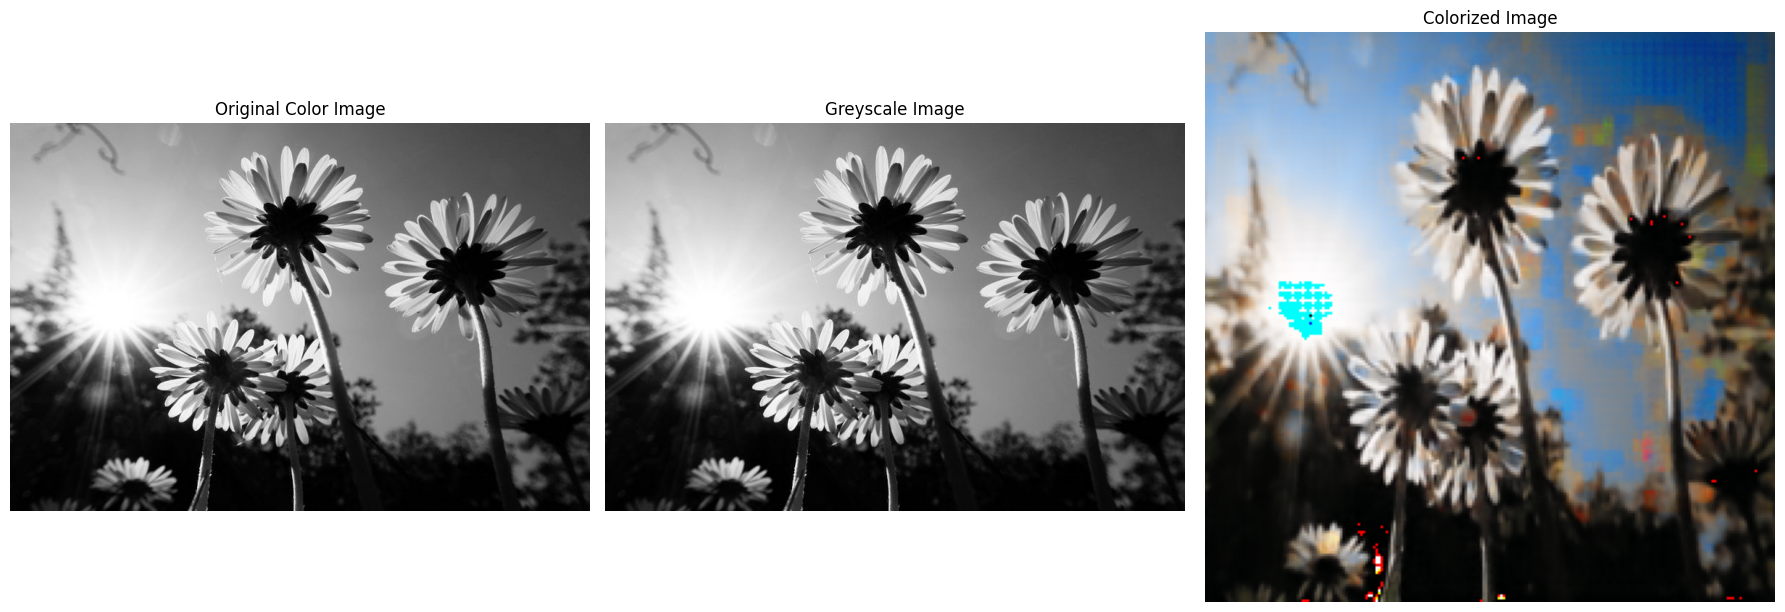

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = np.array(img)
gray_img = np.array(img)
colorized_img = np.array(colorized_img)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

if img.ndim == 3 and img.shape[2] in [3, 4]:
    ax[0].imshow(img)
else:
    ax[0].imshow(np.squeeze(img), cmap='gray')  # For single-channel (grayscale) images
ax[0].set_title("Original Color Image")
ax[0].axis('off')  # Hide axes


if gray_img.ndim == 2:
    ax[1].imshow(gray_img, cmap='gray')  # Since it's grayscale, use cmap='gray'
else:
    ax[1].imshow(np.squeeze(gray_img), cmap='gray')
ax[1].set_title("Greyscale Image")
ax[1].axis('off')


if colorized_img.ndim == 3 and colorized_img.shape[2] in [3, 4]:  # If it's a color image
    ax[2].imshow(colorized_img)
else:
    ax[2].imshow(np.squeeze(colorized_img), cmap='gray')  # In case it's grayscale
ax[2].set_title("Colorized Image")
ax[2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()


In [69]:
import torch
import torchvision.transforms as transforms
from moviepy.editor import VideoFileClip

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

video_url = r'

response = requests.get(video_url, stream=True)
if response.status_code == 200:
    temp_video_path = "temp_video.mp4"
    with open(temp_video_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
else:
    raise Exception(f"Failed to download video. Status code: {response.status_code}")


clip = VideoFileClip(temp_video_path)


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

colorized_frames = []


for frame in clip.iter_frames():

    frame_gray_tensor = transform(frame).unsqueeze(0).to(device)

    with torch.no_grad():
        frame_colorized = model(frame_gray_tensor)

    colorized_frames.append(frame_colorized.cpu())

output_video_path = 'output2_colored_video.mp4'
colorized_clip = VideoFileClip(temp_video_path)
colorized_clip = colorized_clip.set_fps(clip.fps)

colorized_clip.write_videofile(output_video_path)


Moviepy - Building video output2_colored_video.mp4.
Moviepy - Writing video output2_colored_video.mp4



Moviepy - Done !
Moviepy - video ready output2_colored_video.mp4


In [70]:
def colorize_frame(t):
    index = min(int(t * clip.fps), len(colorized_frames) - 1)
    frame_colorized = colorized_frames[index].squeeze(0).permute(1, 2, 0).numpy()
    return (255 * frame_colorized).astype('uint8')

colorized_clip = colorized_clip.fl(lambda gf, t: colorize_frame(t), apply_to=['mask', 'audio'])

colorized_clip.write_videofile(output_video_path, codec='libx264')


Moviepy - Building video output2_colored_video.mp4.
Moviepy - Writing video output2_colored_video.mp4



Moviepy - Done !
Moviepy - video ready output2_colored_video.mp4


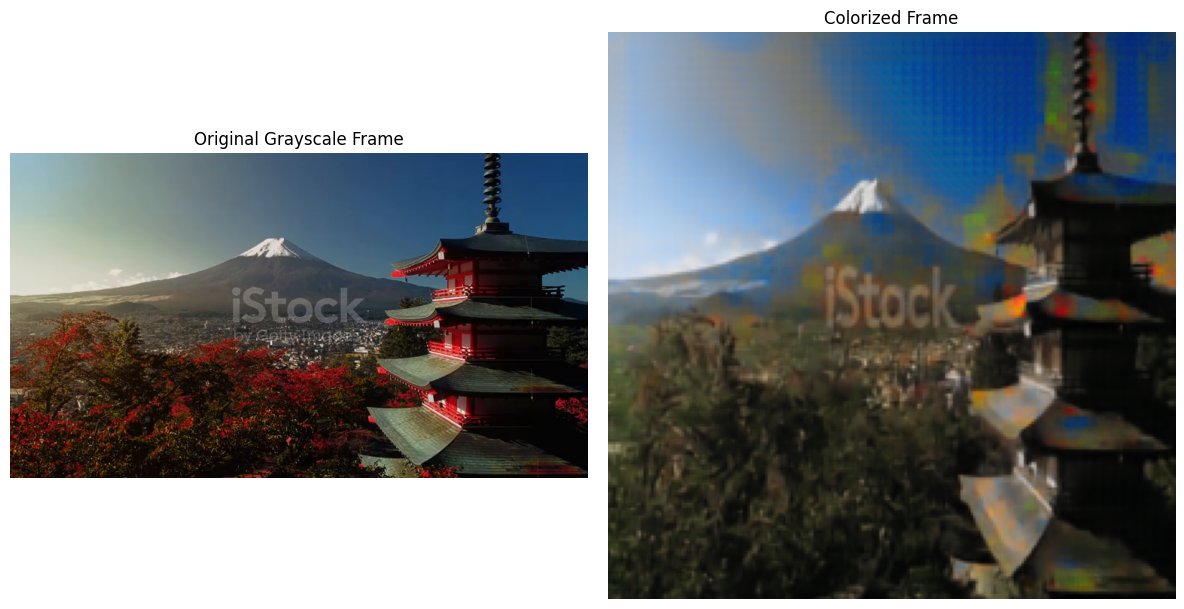

Moviepy - Building video output_colored_video.mp4.
Moviepy - Writing video output_colored_video.mp4



Moviepy - Done !
Moviepy - video ready output_colored_video.mp4


In [71]:
import torch
import torchvision.transforms as transforms
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

video_url = r'https://media.istockphoto.com/id/1344906741/video/autumn-season-in-japan.mp4?s=mp4-640x640-is&k=20&c=ca1HweTm6u3xk3MjEpTvr-mETSl5d8IQ0xHTg8rglWc='

response = requests.get(video_url, stream=True)
if response.status_code == 200:
    temp_video_path = "temp_video.mp4"
    with open(temp_video_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            f.write(chunk)
else:
    raise Exception(f"Failed to download video. Status code: {response.status_code}")


clip = VideoFileClip(temp_video_path)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

colorized_frames = []
original_frames = []

for frame in clip.iter_frames():

    original_frames.append(frame)

    frame_gray_tensor = transform(frame).unsqueeze(0).to(device)

    with torch.no_grad():
        frame_colorized = model(frame_gray_tensor)

    colorized_frames.append(frame_colorized.cpu())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))


axes[0].imshow(np.array(original_frames[0]))
axes[0].set_title("Original Grayscale Frame")
axes[0].axis('off')

# Display the first colorized frame
axes[1].imshow(np.array(colorized_frames[0].squeeze(0).permute(1, 2, 0)))  # Convert to HWC format for display
axes[1].set_title("Colorized Frame")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Optionally, save the colorized video
output_video_path = 'output_colored_video.mp4'
colorized_clip = VideoFileClip(temp_video_path)
colorized_clip = colorized_clip.set_fps(clip.fps)

colorized_clip.write_videofile(output_video_path)
